<p style="font-size:14pt;text-align:center;">
Training Fast R-CNN network on PascalVOC 2005.
</p>

In [205]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys

# image processing
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, hsv2rgb

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params, set_all_param_values
    
import bnr_ml.objectdetect.fastrcnn as fastrcnn
import bnr_ml.utils.helpers as helpers
from bnr_ml.objectdetect.utils import BoundingBox, draw_coord
import bnr_ml.objectdetect.utils as utils

from selectivesearch import selective_search

import pdb

In [2]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.txt', 'rb') as f:
    annotations = pk.load(f)['annotations']

In [3]:
def add_proper_labels(annotations):
    for im in annotations:
        for obj in im:
            if 'car' in obj['label'].lower():
                obj['label'] = 'car'
            elif 'bicycle' in obj['label'].lower():
                obj['label'] = 'bicycle'
            elif 'person' in obj['label'].lower():
                obj['label'] = 'person'
            elif 'motorbike' in obj['label'].lower():
                obj['label'] = 'bike'
            elif 'bike' in obj['label'].lower():
                obj['label'] = 'bicycle'
            else:
                print obj

In [4]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for im in annotations:
        for obj in im:
            if obj['label'] == 0:
                counts[0] += 1
            elif obj['label'] == 1:
                counts[1] += 1
            elif obj['label'] == 2:
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [5]:
def get_num_from_label(obj):
    lab = obj['label'].lower()
    if 'car' == lab:
        obj['label'] = 0
    elif 'bicycle' == lab:
        obj['label'] = 1
    elif 'bike' == lab:
        obj['label'] = 2
    elif 'person' == lab:
        obj['label'] = 3
    else:
        obj['label'] = 4
    return obj

In [6]:
def fix_obj(obj):
    x, y = obj['p1'][0], obj['p1'][1]
    w, h = obj['p2'][0] - x, obj['p2'][1] - y
    obj['x'], obj['y'], obj['w'], obj['h'] = x, y, w, h
    del obj['p1'], obj['p2']
    return get_num_from_label(obj)

In [7]:
add_proper_labels(annotations)

In [8]:
annotations = [[fix_obj(obj) for obj in objs] for objs in annotations]

In [9]:
annotations = np.asarray(annotations)

In [10]:
counts = get_label_counts(annotations)

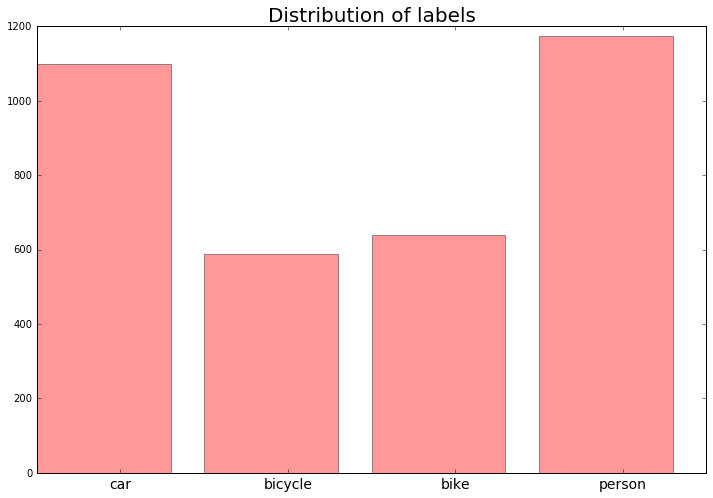

In [11]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [12]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [13]:
with open('indices.pkl', 'rb') as f:
    indices = pk.load(f)
    train_idx = indices['train_index']
    test_idx = indices['test_index']

In [14]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

<b>Fix annotations so that you can use the static method for generating data for fast r-cnn.</b>

<b>Now we define the net for recognition.</b>

In [15]:
num_epochs = 1000
batch_size = 50

In [16]:
num_classes = 4

In [163]:
input_shape = (224,224)
net = {}
net['input'] = InputLayer((None,3) + input_shape)
net['conv1'] = Conv2DLayer(net['input'], 16, (3,3))
net['conv2'] = Conv2DLayer(net['conv1'], 16, (3,3))
net['pool1'] = Pool2DLayer(net['conv2'], (2,2))
net['conv3'] = Conv2DLayer(net['pool1'], 32, (3,3))
net['conv4'] = Conv2DLayer(net['conv3'], 32, (3,3))
net['pool2'] = Pool2DLayer(net['conv4'], (2,2))
net['conv5'] = Conv2DLayer(net['pool2'], 64, (3,3))
net['conv6'] = Conv2DLayer(net['conv5'], 64, (3,3))
net['conv7'] = Conv2DLayer(net['conv6'], 64, (1,1))
net['pool3'] = Pool2DLayer(net['conv7'], (2,2))
net['conv8'] = Conv2DLayer(net['pool3'], 128, (3,3))
net['conv9'] = Conv2DLayer(net['conv8'], 128, (3,3))
net['conv10'] = Conv2DLayer(net['conv9'], 128, (1,1))
net['pool4'] = Pool2DLayer(net['conv10'], (2,2))
net['conv11'] = Conv2DLayer(net['pool4'], 128, (3,3))
net['conv12'] = Conv2DLayer(net['conv11'], 128, (3,3))
net['conv13'] = Conv2DLayer(net['conv12'], 128, (1,1))


net['dense1'] = DenseLayer(dropout(net['conv13'], p=.5), 2048)
# net['dense2'] = DenseLayer(dropout(net['dense1'], p=.5), 2048)
net['dense2'] = DenseLayer(dropout(net['dense1'], p=.5), (2 * 5 + 4) * (6*6))
net['output'] = DenseLayer(dropout(net['dense2'], p=.5), 5, nonlinearity=lasagne.nonlinearities.softmax)

<b>Load pre-trained weights</b>

In [164]:
load_pretrained = True
if load_pretrained:
    with open('pretrained_weights_2.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Add extra layers to network for detection</b>

In [165]:
net['detect'] = net['output']
net['localize'] = DenseLayer(dropout(net['dense2'], p=.5), (num_classes + 1) * 4)

In [166]:
load_weights = False
if load_weights:
    with open('fastrcnn_weights.pkl', 'rb') as f:
        params = pk.load(f)
        tmp = params[:-4]
        tmp.extend(params[-2:])
        set_all_param_values(net['detect'], params[:-2])
        set_all_param_values(net['localize'], tmp)

<b>Train the network

In [195]:
reload(fastrcnn)

<module 'bnr_ml.objectdetect.fastrcnn' from '/usr/local/python/bnr_ml/objectdetect/fastrcnn.py'>

In [196]:
detector = fastrcnn.FastRCNNDetector(net, num_classes)

In [169]:
print_obj = helpers.NotebookPrinter(open('/dev/stdout', 'w'), sys.stdout)

In [170]:
train_gen = fastrcnn.FastRCNNDetector.generate_data(train_annotations, input_shape, num_classes, num_rios=5, per_batch=10)
test_gen = fastrcnn.FastRCNNDetector.generate_data(test_annotations, input_shape, num_classes, num_rios=5, per_batch=10)
train_loss, test_loss = detector.train(
    train_gen,
    test_gen,
    print_obj,
    lr=1e-4,
    lmbda=1.
)

Getting cost...
Compiling...
Compiling took 21.960 seconds
Beginning training
Batch error: 4.4040
Batch error: 1.9365
Batch error: 1.5266
Batch error: 0.6218
Batch error: 0.7257
Batch error: 0.4611
Batch error: 0.5553
Batch error: 0.4711
Batch error: 0.4732
Batch error: 0.2986
Batch error: 0.3918
Batch error: 0.9497
Batch error: 1.1388
Batch error: 0.6816
Batch error: 0.3510
Batch error: 0.5965
Batch error: 0.3249
Batch error: 0.4295
Batch error: 0.7498
Batch error: 0.5715
Batch error: 0.3757
Batch error: 0.6246
Batch error: 0.5331
Batch error: 0.5175
Batch error: 0.6812
Batch error: 0.6980
Batch error: 0.4567
Batch error: 0.4484
Batch error: 0.6137
Batch error: 0.4502
Batch error: 0.4667
Batch error: 0.6015
Batch error: 0.6055
Batch error: 0.4721
Batch error: 0.3693
Batch error: 0.5091
Batch error: 0.5166
Batch error: 0.4571
Batch error: 0.3576
Batch error: 0.7770
Batch error: 0.3991
Batch error: 0.3574
Batch error: 0.4706
Batch error: 0.5049
Batch error: 0.4094
Batch error: 0.6312
Ba

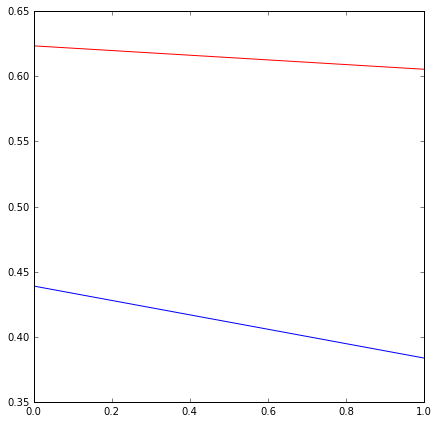

In [171]:
plt.figure(figsize=(7,7))
plt.plot(train_loss, 'b')
plt.plot(test_loss, 'r')

plt.show()

In [172]:
with open('fastrcnn_weights.pkl', 'wb') as f:
    params = [p.get_value() for p in detector.params]
    pk.dump(params, f)

In [180]:
def trans_regions(regions):
    regs = np.zeros((regions.__len__(), 4))
    for i in range(regions.__len__()):
        regs[i] = regions[i]['rect']
    return regs

In [175]:
im = imread(test_annotations[0][0]['image'])

In [176]:
regions = selective_search(im, scale=500, sigma=0.9, min_size=10)

In [181]:
regions = trans_regions(regions[1])

In [224]:
regions.shape

(607, 4)

In [225]:
class_score, coord = detector.detect(im, proposals=regions[400:430])

In [220]:
reload(utils)

<module 'bnr_ml.objectdetect.utils' from '/usr/local/python/bnr_ml/objectdetect/utils.py'>

In [221]:
im_draw = utils.draw_coord(im, coord)

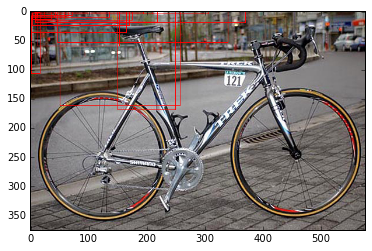

In [222]:
plt.imshow(im_draw)

In [149]:
test_gen = fastrcnn.FastRCNNDetector.generate_data(test_annotations[:10], input_shape, num_classes, num_rios=5, per_batch=10)
tmp = [t for t in test_gen]

In [150]:
X,y = tmp[0]

In [151]:
swap = lambda x: x.swapaxes(0,1).swapaxes(1,2)

In [160]:
ps = np.where(y[:,-5:].argmax(axis=1)!=4)[0]
print ps
print float(ps.size) / X.shape[0]

[ 0  4  6  7 13 14 18 19 24 28 34 40 47]
0.26


In [153]:
def map_back(coord, size):
    coord = np.copy(coord)
    coord[[2,3]] = np.exp(coord[[2,3]])
    coord[[0,2]] = coord[[0,2]] * size[1]
    coord[[1,3]] = coord[[1,3]] * size[0]
    return coord

In [161]:
N = 13
im, lab = swap(X[N]), y[N]; lab[:4] = map_back(lab[:4], (224,224))

[  -3.64213514    3.36431718  239.38497925  230.71395874    0.            0.
    0.            1.            0.        ]


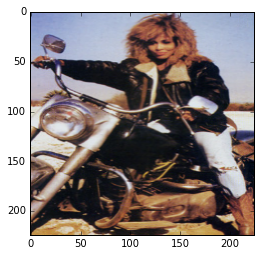

In [162]:
plt.imshow(im)
print lab

{'h': 68, 'image': '/usr/local/python/bnr_ml/data/PascalVOC/VOC2005_1/PNGImages/ETHZ_sideviews-cars/29045-sml-lt.png', 'label': 0, 'w': 225, 'y': 49, 'x': 42}


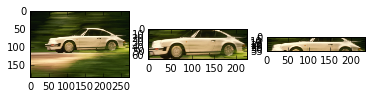

In [131]:
N, M = 9, 0
obj = test_annotations[N][M]
im = imread(obj['image'])
plt.subplot(1,3,1)
plt.imshow(im)
print obj
bx = BoundingBox(
    obj['x'],
    obj['y'],
    obj['x'] + obj['w'],
    obj['y'] + obj['h']
)
plt.subplot(1,3,2)
plt.imshow(bx.subimage(im))

plt.subplot(1,3,3)
plt.imshow(BoundingBox.gen_randombox(.5, bx).subimage(im))